In [1]:
import spacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import fitz
import pdfplumber
from transformers import pipeline
import os
from datetime import date
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def getFilelist(foldername):
    filelist = []
    for dirname, _, filenames in os.walk(foldername):
        for filename in filenames:
            filelist.append(os.path.join(dirname, filename))
    return filelist

def createfolder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

## Report details

In [3]:
report_company = 'Fluence Energy'
report_ticker = 'FLNC'
report_years = ['2022','2023','2024']

## Text cleaning

### Text Extraction
Extract information from the PDF report.

In [4]:
def extract_pdf(file, verbose=False):
    
    if verbose:
        print('Processing {}'.format(file))

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        codec = 'utf-8'
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, codec=codec, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        content = []

        with open(file, 'rb') as fh:
            for page in PDFPage.get_pages(fh,
                                          pagenos, 
                                          maxpages=maxpages,
                                          password=password,
                                          caching=True,
                                          check_extractable=False):

                page_interpreter.process_page(page)

                content.append(fake_file_handle.getvalue())

                fake_file_handle.truncate(0)
                fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""
    

In [5]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# PDF text extraction
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Others
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io
import json
import numpy as np

# Import td-idf and count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

d:\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [6]:
# 赋值pdf文件
pdf_files = ['2022.Sep.pdf', '2023.Sep.pdf', '2024.Sep.pdf']
pdf_texts = {}

for pdf_file in pdf_files:
    file_path = f"C:\\Users\\Kevin\\OneDrive\\Desktop\\MQF学习资料\\files of lessons\\winter quarter\\MGTF 423\\final projects\\10-ks\\{pdf_file}"
    pdf_texts[pdf_file] = extract_pdf(file_path, verbose=True)

Processing C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\10-ks\2022.Sep.pdf
Processing C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\10-ks\2023.Sep.pdf
Processing C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\10-ks\2024.Sep.pdf


### test pdf_texts

### Storing all information in a json file

In [7]:
DATA_FOLDER = '../data/'
PDF_FOLDER = '../pdf/'
createfolder(DATA_FOLDER)
createfolder(PDF_FOLDER)

In [8]:
for year in report_years:
    report = {'company': report_company, 'year': year, 'ticker': report_ticker, 'content': pdf_texts[f'{year}.Sep.pdf']}
    with open(DATA_FOLDER + report_company + year + '.json', "w") as outfile:  
        json.dump(report, outfile)  # 将2022，2023，2024年的10-ks字典写入json文件

### Reload the json file when needed

In [9]:
DATA_FOLDER = r"C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\data\\"

In [10]:
for year in report_years:
    with open(DATA_FOLDER + report_company + year + '.json') as inputfile:
        report[year] = json.load(inputfile)
        print(f"report['{year}'] has been loaded from the json file")

report['2022'] has been loaded from the json file
report['2023'] has been loaded from the json file
report['2024'] has been loaded from the json file


## Natural Language Processing

### Loading NLP model

In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Preparing Stop Words

Here we combine the two stopwords sets(nltk & Scikit-learn) to get a more comprehensive Stop words
1. Reduce Noise: Stop words frequently appear in text but do not contribute much to the meaning. Removing them helps reduce noise in the data.
2. Improve Efficiency: By removing stop words, the dimensionality of the text data is reduced, which can improve the efficiency of text processing and analysis.

In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

', '.join(stop_words)

"your, interest, anyway, whether, becoming, needn't, once, almost, often, empty, give, it's, show, at, herein, become, formerly, she'd, back, eleven, sometime, o, doesn, bottom, nothing, something, ours, too, there, beyond, don, himself, between, myself, not, why, couldn't, thus, than, became, further, about, four, wherever, hereupon, through, i'm, thereby, first, again, less, therein, afterwards, whole, has, over, put, whence, must, anywhere, don't, see, together, shouldn't, didn, aren, meanwhile, anyhow, only, hasnt, within, who, here, they, she's, it'd, thru, whoever, up, several, is, hasn, he's, with, i'd, it'll, whereupon, nor, theirs, bill, by, am, more, seem, ltd, i'll, whereas, upon, you've, please, also, becomes, after, thereupon, mill, call, might, her, can, namely, so, co, even, anything, i've, now, keep, does, in, every, won, s, t, five, mine, front, before, same, whereafter, next, it, hasn't, you're, much, he, mustn't, seeming, though, could, i, each, per, anyone, while, s

### Extracting content by pages and sentences

1. Only properly structured sentences are extracted.  Sentences that start with a Capital Letter and ends with a period.  Sentences that are less than 10 words or more than 50 words are ignored.  
2. Pages with less than 500 words are excluded from extraction.  Would like to focus on pages with mostly text content.  This should exclude pages like cover and last page.  It should also exclude pages that are more graphical with short notes and comments.

In [13]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))
# 保留可打印字符

def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    return not line.isupper()
# 不包括大写字母

def extract_sentences(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
    MIN_WORDS_PER_PAGE = 500
 # 每页最少500个单词（将封面或者大面积图像的页面剔除）   
    pages = text.split('##PAGE_BREAK##')
#     print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for page in pages:
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
#             print('Skipped Page: {}'.format(len(text.split(' '))))
            continue
        
        prev = ""
        # aggregate consecutive lines where text may be broken down
        for line in text.split('\n\n'):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    sentences = []
    pages_content = []

    for line in lines[:-1]:
        # removing header number
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        # removing trailing spaces
        line = line.strip()
        # words may be split between lines, ensure we link them back together
        line = re.sub(r'\s?-\s?', '-', line)
        # remove space prior to punctuation
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        # ESG contains a lot of figures that are not relevant to grammatical structure
        line = re.sub(r'\d{5,}', r' ', line)
        # remove emails
        line = re.sub(r'\S*@\S*\s?', '', line)
        # remove mentions of URLs
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        # remove multiple spaces
        line = re.sub(r'\s+', ' ', line)
        # join next line with space
        line = re.sub(r' \n', ' ', line)
        line = re.sub(r'.\n', '. ', line)
        line = re.sub(r'\x0c', ' ', line)
        
        pages_content.append(str(line).strip())

        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

#           sentences += nltk.sent_tokenize(line)
            
    # Only interested in full sentences and sentences with 10 to 100 words.
    sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
    sentences = [s.replace('\n', ' ') for s in sentences]
    sentences = [s for s in sentences if (len(s.split(' ')) > 10) & (len(s.split(' ')) < 100)]

    return pages_content, sentences

In [14]:
for year in report_years:
    pages, sentences = extract_sentences(nlp, report[year]['content'])
    globals()[f'report_{year}_pages'] = pages
    globals()[f'report_{year}_sentences'] = sentences

### Tokenization, Bigrams and Lemmatization

In [15]:
def run_NLP(content):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized


In [16]:
data_lemmatized = {}
report_sentences_lemma = {}

for year in report_years:
    data_lemmatized[year] = run_NLP(globals()[f'report_{year}_pages'])
    report_sentences_lemma[year] = [' '.join(w) for w in data_lemmatized[year]]
    print(report_sentences_lemma[year][random.randint(0, len(report_sentences_lemma[year]))])

item business inception organization fluence energy form conduct business operation fluence energy llc direct indirect_subsidiarie fluence energy llc form joint venture indirect subsidiary indirect subsidiary ae corporation ae commence operation refer stability founder fluence energy llc enter agreement qfh blocker company investment accelerate growth global deployment offering qfh affiliate investment sovereign wealth fund subsidiary affiliate follow completion transaction stability qfh collectively original llc owner hold respectively limited liability interest llc interest fluence energy llc content clearly indicate reference fluence company refer fluence energy direct indirect_subsidiarie include fluence energy llc use historical context prior completion ipo define company refer fluence energy llc subsidiary initial public_offere relate transaction company complete initial public_offere ipo issue sell share stock par_value share public_offere price share include exercise underwrite

In [17]:
stop_words = set()
fsi_stop_words = [ 
  'plc', 'INC', 'inc', 'LLC', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'government',
  'long', 'make', 'disclosure', 'disclose', 'include', 
  'company', 'service', 'services'
]
fsi_stop_words.append(report_company)
for word in report_company.split():
  fsi_stop_words.append(word)
fsi_stop_words.append('fluence')
stop_words = stop_words.union(fsi_stop_words)

In [18]:
from wordcloud import WordCloud
# Create a WordCloud object

In [ ]:
# Create a dictionary to map years to the corresponding variables
for year in report_years:
    # aggregate all records into one large string to run wordcloud on term frequency
    large_string = ' '.join(report_sentences_lemma[year])

    # use 3rd party lib to compute term freq., apply stop words
    word_cloud = WordCloud(
        background_color="white",
        max_words=5000, 
        width=1500, 
        height=1000, 
        stopwords=stop_words, 
        contour_width=3, 
        contour_color='steelblue'
    )

    # display our wordcloud across all records
    plt.figure(figsize=(16,16))
    word_cloud.generate(large_string)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['energy', 'llc'] not in stop_words.
  warnings.warn(
d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


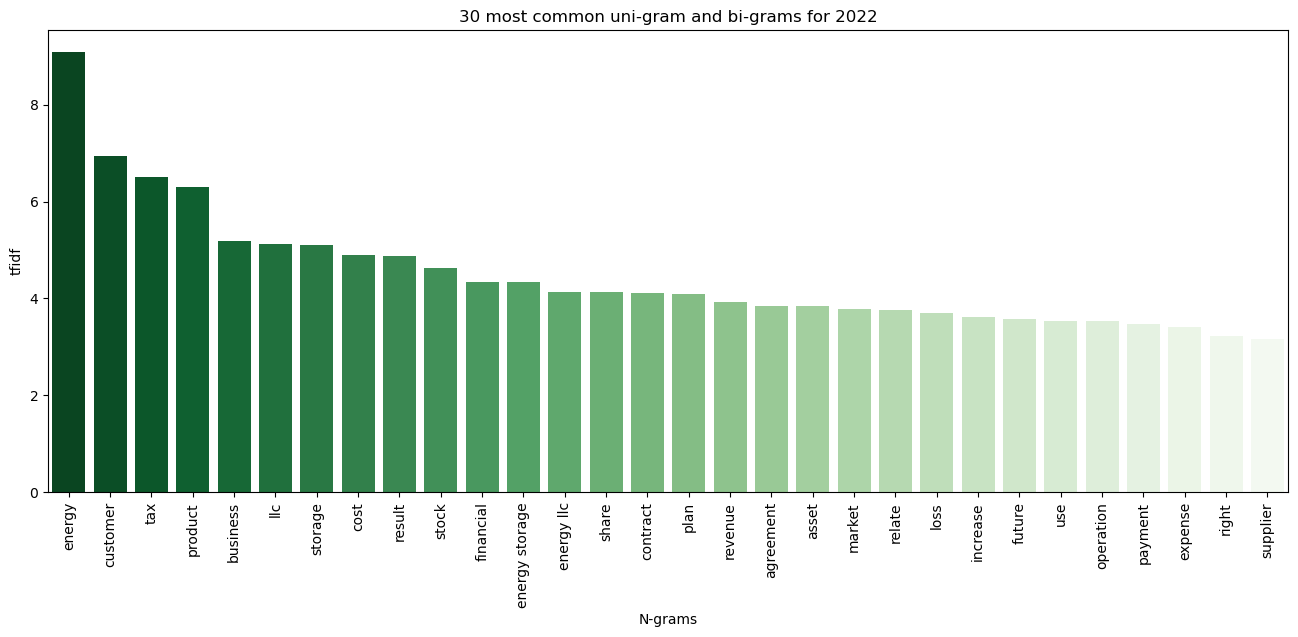

d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['energy', 'llc'] not in stop_words.
  warnings.warn(
d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


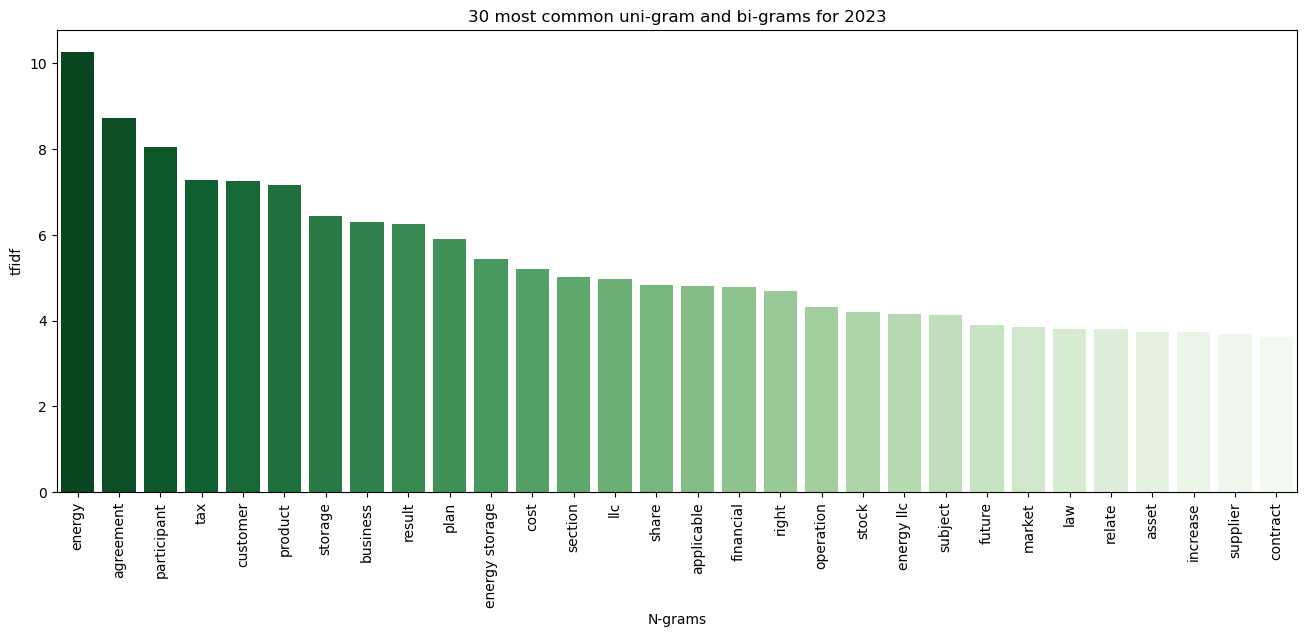

d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['energy', 'llc'] not in stop_words.
  warnings.warn(
d:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


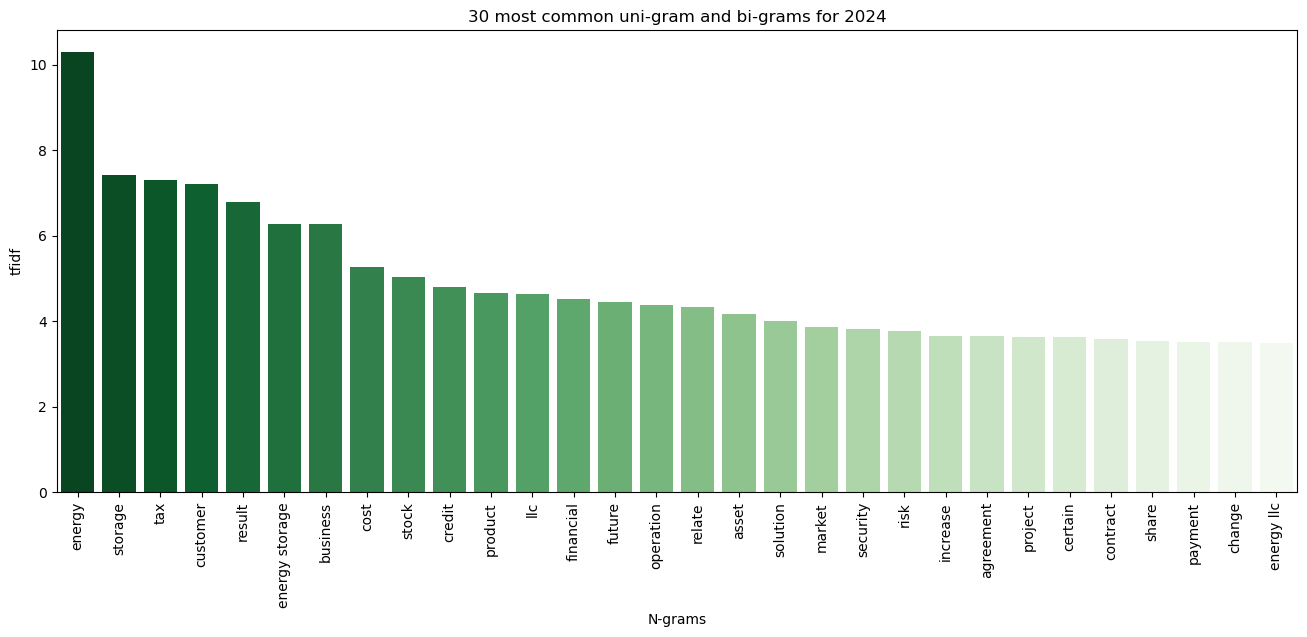

In [ ]:
# 生成图表保存路径并保存图片
for year in report_years: 
    # Run bi-gram TF-IDF frequencies
    bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=10, use_idf=True)
    bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(report_sentences_lemma[year])

    # Extract bi-grams names
    words = bigram_tf_idf_vectorizer.get_feature_names_out()

    # extract our top 10 ngrams
    total_counts = np.zeros(len(words))
    for t in bigram_tf_idf:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    # Plot top 10 ngrams
    plt.figure(figsize=(16, 6))
    plt.subplot(title=f'30 most common uni-gram and bi-grams for {year}')
    sns.barplot(x_pos, counts, palette='Greens_r')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('N-grams')
    plt.ylabel('tfidf')

    # 保存图片
    filename = f"ngrams_top30_{year}.png"

    plt.show()

### Model selection

Evaluaton Metrics
1. **Perplexity**: Captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.  Lower the better.
2. **Coherence Score**: Measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.  Higher the better.

In the analysis, the model with the highest coherence score is selected as the optimal model.

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized['2022'])

# Create Corpus
texts = data_lemmatized['2022']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
output_dir = r"C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\\"
os.makedirs(output_dir, exist_ok=True)

  0%|          | 0/7 [00:00<?, ?it/s]

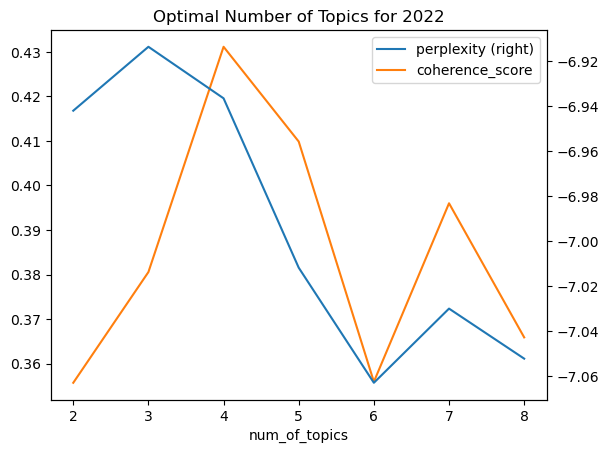


Perplexity of the Optimal Model for 2022:  -6.936387822563755

Coherence Score of the Optimal Model for 2022:  0.43115495971671525


d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.096796  0.058113       1        1  37.201662
0     -0.072659 -0.242349       2        1  31.320156
1     -0.139556  0.153633       3        1  22.893773
2      0.309010  0.030603       4        1   8.584409, topic_info=          Term        Freq       Total Category  logprob  loglift
46   financial  205.000000  205.000000  Default  30.0000  30.0000
167   contract  235.000000  235.000000  Default  29.0000  29.0000
252       plan  170.000000  170.000000  Default  28.0000  28.0000
472        tax  245.000000  245.000000  Default  27.0000  27.0000
279    service  267.000000  267.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
27      define   20.135814   43.337081   Topic4  -5.0196   1.6887
74      period   27.905270  129.169710   Topic4  -4.6933   0.9229
84     quarter   21.189477   60.883444   Topic4  -4.9686   1.3998
372    present   18.572608   37.230057   Topic4  -5.1005   1.7598
18     company   20.323312  393.159348   Topic4  -5.0104  -0.5072

[256 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
122       1  0.850639  ability
122       2  0.147444  ability
1410      1  0.987133     able
405       2  0.332562  account
405       3  0.651822  account
...     ...       ...      ...
304       1  0.989977   vendor
821       3  0.937645     work
595       1  0.015487     year
595       2  0.707243     year
595       3  0.273605     year

[349 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

Saved LDA visualization for 2022 to: C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\\LDA_vis_2022.html


  0%|          | 0/7 [00:00<?, ?it/s]

d:\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
d:\anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


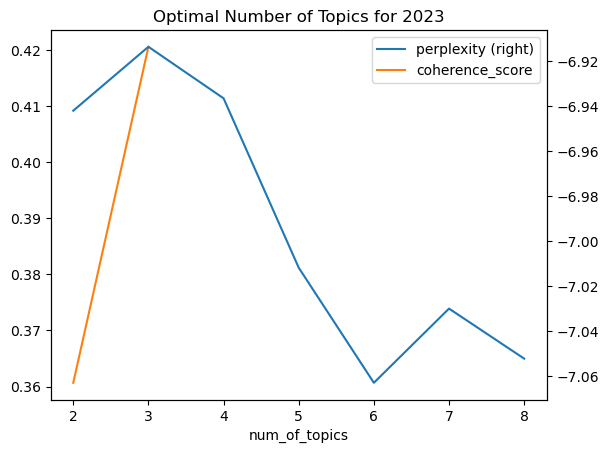


Perplexity of the Optimal Model for 2023:  -6.91346841683721

Coherence Score of the Optimal Model for 2023:  0.4205277916239319


d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.127985  0.159541       1        1  50.423316
0     -0.124885 -0.160850       2        1  38.972197
2      0.252871  0.001309       3        1  10.604487, topic_info=            Term        Freq       Total Category  logprob  loglift
46     financial  213.000000  213.000000  Default  30.0000  30.0000
252         plan  126.000000  126.000000  Default  29.0000  29.0000
472          tax  266.000000  266.000000  Default  28.0000  28.0000
625         cost  345.000000  345.000000  Default  27.0000  27.0000
87    registrant  102.000000  102.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
172         date   28.889266  147.575497   Topic3  -4.8700   0.6130
222  information   24.578246   70.988329   Topic3  -5.0316   1.1832
84       quarter   22.407711   57.444655   Topic3  -5.1241   1.3025
18       company   28.329848  405.491973   Topic3  -4.8896  -0.4173
55       include   21.516462  334.554745   Topic3  -5.1647  -0.5001

[197 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2674      1  0.061463    achievement
2674      3  0.921946    achievement
1756      1  0.023054     adjustment
1756      2  0.968250     adjustment
2697      1  0.048386  administrator
...     ...       ...            ...
819       1  0.946352       warranty
819       2  0.053316       warranty
595       1  0.364784           year
595       2  0.342897           year
595       3  0.291827           year

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

Saved LDA visualization for 2023 to: C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\\LDA_vis_2023.html


  0%|          | 0/7 [00:00<?, ?it/s]

d:\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
d:\anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


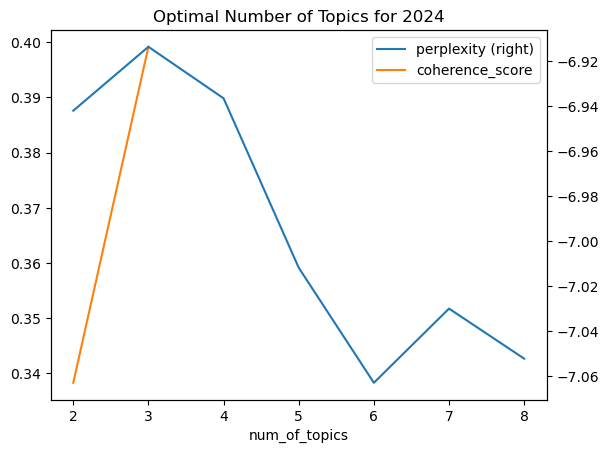


Perplexity of the Optimal Model for 2024:  -6.91346841683721

Coherence Score of the Optimal Model for 2024:  0.39918965153791824


d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.127985  0.159541       1        1  50.423316
0     -0.124885 -0.160850       2        1  38.972197
2      0.252871  0.001309       3        1  10.604487, topic_info=            Term        Freq       Total Category  logprob  loglift
46     financial  213.000000  213.000000  Default  30.0000  30.0000
252         plan  126.000000  126.000000  Default  29.0000  29.0000
472          tax  266.000000  266.000000  Default  28.0000  28.0000
625         cost  345.000000  345.000000  Default  27.0000  27.0000
87    registrant  102.000000  102.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
172         date   28.889266  147.575497   Topic3  -4.8700   0.6130
222  information   24.578246   70.988329   Topic3  -5.0316   1.1832
84       quarter   22.407711   57.444655   Topic3  -5.1241   1.3025
18       company   28.329848  405.491973   Topic3  -4.8896  -0.4173
55       include   21.516462  334.554745   Topic3  -5.1647  -0.5001

[197 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2674      1  0.061463    achievement
2674      3  0.921946    achievement
1756      1  0.023054     adjustment
1756      2  0.968250     adjustment
2697      1  0.048386  administrator
...     ...       ...            ...
819       1  0.946352       warranty
819       2  0.053316       warranty
595       1  0.364784           year
595       2  0.342897           year
595       3  0.291827           year

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

Saved LDA visualization for 2024 to: C:\Users\Kevin\OneDrive\Desktop\MQF学习资料\files of lessons\winter quarter\MGTF 423\final projects\\LDA_vis_2024.html


In [24]:
# View
for year in report_years:
    results = []
    optimal_score = 0
    optimal_model = None

    for num_of_topics in tqdm(range(2, 9, 1)):
        result = {}

        # Build LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_of_topics,
                                                    random_state=42,
                                                    update_every=1,
                                                    chunksize=5,
                                                    passes=20,
                                                    alpha='auto',
                                                    per_word_topics=True)

        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized[year], dictionary=id2word, coherence='c_v')

        if optimal_score < coherence_model_lda.get_coherence():
            optimal_score = coherence_model_lda.get_coherence()
            optimal_model = lda_model

        result['num_of_topics'] = num_of_topics
        result['perplexity'] = lda_model.log_perplexity(corpus)
        result['coherence_score'] = coherence_model_lda.get_coherence()

        results.append(result)

    results = pd.DataFrame(results)
    results.set_index('num_of_topics', inplace=True)
    results.plot(secondary_y='perplexity')
    plt.title(f'Optimal Number of Topics for {year}')
    plt.show()

    # Compute Perplexity
    print(f'\nPerplexity of the Optimal Model for {year}: ', optimal_model.log_perplexity(corpus))

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized[year], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'\nCoherence Score of the Optimal Model for {year}: ', coherence_lda)

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
    display(vis)

    filename = f"LDA_vis_{year}.html"
    save_path = os.path.join(output_dir, filename)
    pyLDAvis.save_html(vis, save_path)
    print(f"Saved LDA visualization for {year} to: {save_path}")

## ESG - Environmental text classification

In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
 
tokenizer_name = "ESGBERT/EnvironmentalBERT-environmental"
model_name = "ESGBERT/EnvironmentalBERT-environmental"
 
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, max_len=512)
 
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device = 0) # set device=0 to use GPU
 
# See https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline
print(pipe("Scope 1 emissions are reported here on a like-for-like basis against the 2013 baseline and exclude emissions from additional vehicles used during repairs.", padding=True, truncation=True))

Device set to use cpu


[{'label': 'environmental', 'score': 0.9979760050773621}]


In [26]:
# load the model configuration
config = model.config

if hasattr(config, 'id2label'):
    print("Label mapping (id to label):")
    for id, label in config.id2label.items():
        print(f"{id}: {label}")
else:
    print("The model configuration does not contain label mapping information.")

Label mapping (id to label):
0: none
1: environmental


### Test the model with a single sentence

Here, we...

In [27]:
test_sentence = "Scope 1 emissions are reported here on a like-for-like basis against the 2013 baseline and exclude emissions from additional vehicles used during repairs."
result = pipe(test_sentence, padding=True, truncation=True)
print(result)

[{'label': 'environmental', 'score': 0.9979760050773621}]


### Classify sentences in the reports

In [ ]:
env_counts = []
years = []

for year in report_years:
    result = []
    sentences = globals()[f'report_{year}_sentences']
    for text in sentences:
        result.append(pipe(text, padding=True, truncation=True))

    flattened_results = [item for sublist in result for item in sublist]
    df_result = pd.DataFrame(flattened_results)
    df_result['sentence'] = sentences

    none_count = sum(1 for res in result if res[0]['label'] == 'environmental')
    print(f"Number of 'environmental' labels for {year}: {none_count}")

    df_environmental = df_result[df_result['label'] == 'environmental']
    df_environmental.to_csv(f'{DATA_FOLDER}{report_company}_{year}_environmental.csv', index=False)

    years.append(year)
    env_counts.append(none_count)

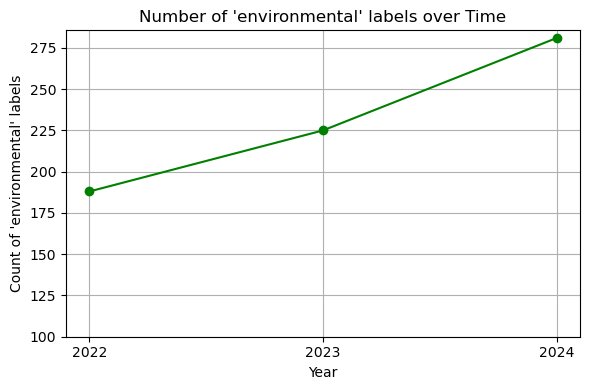

In [29]:

plt.figure(figsize=(6, 4))
plt.plot(years, env_counts, marker='o', color='green')
plt.ylim(bottom=100)
plt.xlabel("Year")
plt.ylabel("Count of 'environmental' labels")
plt.title("Number of 'environmental' labels over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
for year in report_years:
    result = []
    sentences = globals()[f'report_{year}_sentences']
    for text in sentences:
        result.append(pipe(text, padding=True, truncation=True))

    flattened_results = [item for sublist in result for item in sublist]
    df_result = pd.DataFrame(flattened_results)

    df_result['sentence'] = sentences

    none_count = sum(1 for res in result if res[0]['label'] == 'environmental')
    print(f"Number of 'environmental' labels for {year}: {none_count}")

    df_environmental = df_result[df_result['label'] == 'environmental']
    df_environmental.to_csv(f'{DATA_FOLDER}{report_company}_{year}_environmental.csv', index=False)

Number of 'environmental' labels for 2022: 188
Number of 'environmental' labels for 2023: 225
Number of 'environmental' labels for 2024: 281


In [35]:
ESG_2022 = pd.read_csv(DATA_FOLDER + report_company + '_2022_environmental.csv')
ESG_2023 = pd.read_csv(DATA_FOLDER + report_company + '_2023_environmental.csv') 
ESG_2024 = pd.read_csv(DATA_FOLDER + report_company + '_2024_environmental.csv')

### Load Fin_Senti_Classfication Model

Here, we...

In [30]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [31]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

Device set to use cpu


In [32]:
# load the configuration
config = model.config

if hasattr(config, 'id2label'):
    print("Label mapping (id to label):")
    for id, label in config.id2label.items():
        print(f"{id}: {label}")
else:
    print("The model configuration does not contain label mapping information.")

Label mapping (id to label):
0: negative
1: neutral
2: positive


In [37]:
globals()['ESG_2022'] = ESG_2022
globals()['ESG_2023'] = ESG_2023
globals()['ESG_2024'] = ESG_2024

Number of 'negative' labels for 2022: 34
Number of 'neutral' labels for 2022: 106
Number of 'positive' labels for 2022: 48
Number of 'negative' labels for 2023: 50
Number of 'neutral' labels for 2023: 113
Number of 'positive' labels for 2023: 62
Number of 'negative' labels for 2024: 56
Number of 'neutral' labels for 2024: 144
Number of 'positive' labels for 2024: 81


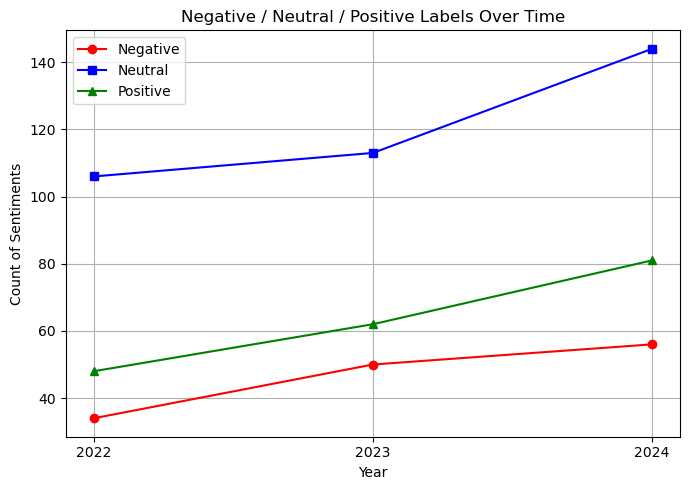

In [ ]:
years = []
negative_counts = []
neutral_counts = []
positive_counts = []

for year in report_years:
    result = []
    sentences = globals()[f'ESG_{year}']['sentence'].tolist()
    for text in sentences:
        result.append(pipe(text, padding=True, truncation=True))

    flattened_results = [item for sublist in result for item in sublist]

    none_count_01 = sum(1 for res in flattened_results if res['label'] == 'negative')
    none_count_02 = sum(1 for res in flattened_results if res['label'] == 'neutral')
    none_count_03 = sum(1 for res in flattened_results if res['label'] == 'positive')

    print(f"Number of 'negative' labels for {year}: {none_count_01}")
    print(f"Number of 'neutral' labels for {year}: {none_count_02}")
    print(f"Number of 'positive' labels for {year}: {none_count_03}")

    years.append(year)
    negative_counts.append(none_count_01)
    neutral_counts.append(none_count_02)
    positive_counts.append(none_count_03)

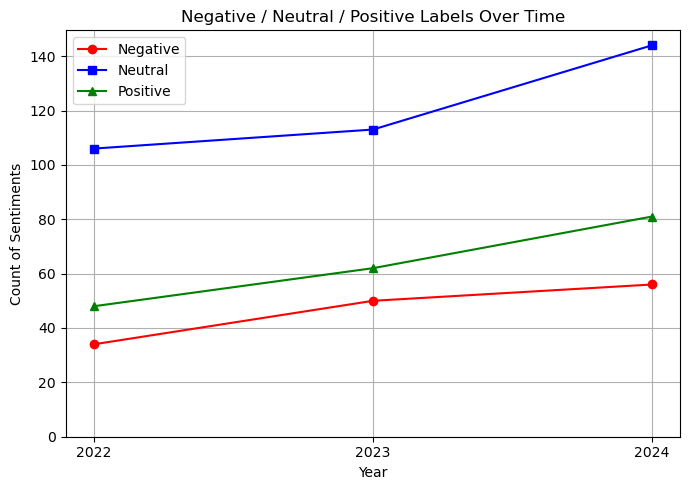

In [39]:
plt.figure(figsize=(7, 5))

plt.plot(years, negative_counts, marker='o', color='red', label='Negative')
plt.plot(years, neutral_counts, marker='s', color='blue', label='Neutral')
plt.plot(years, positive_counts, marker='^', color='green', label='Positive')
plt.ylim(bottom=0)
plt.xlabel("Year")
plt.ylabel("Count of Sentiments")
plt.title("Negative / Neutral / Positive Labels Over Time")
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()